In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import sklearn
import shap
%matplotlib inline
from xgboost import XGBClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay

In [2]:
plt.style.use("seaborn")

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/mena_2021_access.csv")
IND_u= pd.read_csv('../Datasets/mena_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

0    7829
1    1224
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,1.0,2,5
1,2,5.0,1,1
2,2,2.0,3,5
3,2,1.0,2,1
4,2,5.0,2,4
...,...,...,...,...
9048,1,4.0,1,5
9049,2,2.0,3,5
9050,2,5.0,3,5
9051,2,3.0,1,5


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,723,634,520,478,429
2,658,824,977,1047,1060
3,108,148,299,407,741


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

In [8]:
IND_a= IND_a.drop(columns= ["account_mob", "fin1_1a", "fin1_1b"])
IND_a

,account_fin,fin2,fin7,mobileowner,internetaccess
0,Yes,Yes,No,Yes,Yes
1,Yes,No,No,Yes,No
2,Yes,Yes,No,Yes,Yes
3,No,No,NaN,Yes,Yes
4,Yes,Yes,No,Yes,Yes
...,...,...,...,...,...
9048,No,No,NaN,Yes,Yes
9049,No,No,NaN,Yes,Yes
9050,Yes,Yes,Yes,Yes,Yes
9051,Yes,Yes,No,Yes,Yes


In [9]:
IND_u= IND_u.drop(columns= ["fin1_1a", "fin1_1b", "fin26", "fin28","fin17b", "merchantpay_dig"])
IND_u

,fin4,fin5,fin8,fin9,fin10,fin10b,fin14_1,fin14a,fin14a1,fin14b,...,fin22b,fin30,fin31a,fin31b,fin32,fin37,fin38,saved,borrowed,anydigpayment
0,No,No,NaN,Yes,Yes,Yes,2,No,No,No,...,No,No,NaN,NaN,No,2,No,1,2,2
1,NaN,No,NaN,Yes,Yes,No,2,No,No,No,...,Yes,Yes,No,No,Yes,1,No,2,1,1
2,Yes,Yes,NaN,Yes,Yes,Yes,2,No,No,No,...,Yes,Yes,No,No,Yes,2,No,1,1,1
3,NaN,NaN,NaN,NaN,NaN,NaN,1,Yes,Yes,Yes,...,Yes,Yes,No,No,Yes,1,No,1,1,2
4,No,Yes,NaN,Yes,Yes,Yes,1,No,No,No,...,No,Yes,No,No,No,2,No,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9048,NaN,NaN,NaN,NaN,NaN,NaN,2,No,No,No,...,No,No,NaN,NaN,No,2,No,2,2,2
9049,NaN,NaN,NaN,NaN,NaN,NaN,2,Yes,No,No,...,Yes,No,NaN,NaN,No,2,No,2,1,2
9050,No,Yes,Yes,Yes,Yes,Yes,2,No,No,No,...,Yes,Yes,No,No,No,2,No,1,1,1
9051,No,No,NaN,No,No,Yes,2,No,No,No,...,No,No,NaN,NaN,No,2,No,2,2,2


## Implementing MCA

In [10]:
mca_a = prince.MCA(n_components=6)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6
0,-0.836756,-0.020990,-0.199208,0.129372,-0.104702,0.008827
1,-0.149152,0.524950,-0.276050,-0.608852,0.548677,-0.150141
2,-0.836756,-0.020990,-0.199208,0.129372,-0.104702,0.008827
3,0.598920,-0.473651,-0.002908,0.094458,-0.048852,-0.003607
4,-0.836756,-0.020990,-0.199208,0.129372,-0.104702,0.008827
...,...,...,...,...,...,...
9048,0.598920,-0.473651,-0.002908,0.094458,-0.048852,-0.003607
9049,0.598920,-0.473651,-0.002908,0.094458,-0.048852,-0.003607
9050,-0.884924,-0.165435,2.050052,-0.176199,-0.018214,-0.008319
9051,-0.836756,-0.020990,-0.199208,0.129372,-0.104702,0.008827


In [11]:
mca_u = prince.MCA(n_components=20)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,uPC11,uPC12,uPC13,uPC14,uPC15,uPC16,uPC17,uPC18,uPC19,uPC20
0,0.247127,0.132824,0.745597,0.170411,-0.707251,-0.149208,0.018269,-0.083272,-0.031562,0.017804,-0.040633,-0.007348,0.083140,0.003927,-0.133311,0.078316,-0.234337,-0.291005,-0.088684,0.182044
1,0.235353,0.476273,-0.378236,-0.095581,0.099202,-0.388815,-0.063719,0.352339,0.073788,-0.014042,0.364891,-0.141355,-0.082340,0.084455,0.195854,-0.070683,0.099803,0.031314,-0.084445,-0.053056
2,0.830560,0.071105,-0.002663,-0.384856,-0.588234,-0.413911,-0.017226,-0.037337,-0.013921,0.003738,-0.448802,0.120693,-0.085895,-0.021017,0.251342,-0.164312,-0.187951,-0.005784,0.138102,-0.337951
3,0.784634,-0.548973,-0.410244,-0.672366,-0.194892,0.702656,-0.060786,0.217087,0.031410,0.007606,0.516071,-0.254127,-0.045807,0.178366,0.225574,-0.140141,-0.254436,0.388850,0.207842,0.466949
4,0.635469,0.098681,0.610924,-0.378762,-0.444523,0.131964,-0.004367,0.061758,-0.022207,-0.015069,0.131492,0.128063,-0.051295,-0.190917,0.000858,0.129280,-0.132016,-0.244371,-0.110789,0.270355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9048,-0.623072,-0.279495,0.272194,0.170336,0.144098,-0.053256,-0.013659,-0.027453,-0.012219,-0.008864,-0.062225,0.030242,0.003280,-0.016947,-0.005468,0.018072,-0.003260,-0.003172,-0.004052,0.028334
9049,-0.293781,-0.486204,-0.487756,0.125603,0.027844,-0.048305,0.008747,-0.157643,-0.002777,0.013321,-0.081583,-0.133676,0.183962,-0.000967,-0.277412,0.058495,-0.135023,0.109266,-0.086138,0.100991
9050,0.784764,0.181676,-0.006198,-0.302700,-0.645690,-0.272773,0.014487,-0.247639,-0.069585,0.016390,-0.654579,0.528784,-0.473991,-0.208095,0.162247,0.283583,0.119362,0.015043,-0.395346,0.422963
9051,-0.248017,0.400383,0.229794,0.574315,-0.010370,0.400993,0.000710,-0.102177,-0.011701,-0.032354,-0.265699,-0.113725,0.008402,0.045753,0.011498,0.274713,-0.152478,-0.118961,0.302519,0.187245


In [12]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,uPC1,uPC2,uPC3,uPC4,...,uPC15,uPC16,uPC17,uPC18,uPC19,uPC20,female,age,educ,inc_q
0,-0.836756,-0.020990,-0.199208,0.129372,-0.104702,0.008827,0.247127,0.132824,0.745597,0.170411,...,-0.133311,0.078316,-0.234337,-0.291005,-0.088684,0.182044,1,1.0,2,5
1,-0.149152,0.524950,-0.276050,-0.608852,0.548677,-0.150141,0.235353,0.476273,-0.378236,-0.095581,...,0.195854,-0.070683,0.099803,0.031314,-0.084445,-0.053056,2,5.0,1,1
2,-0.836756,-0.020990,-0.199208,0.129372,-0.104702,0.008827,0.830560,0.071105,-0.002663,-0.384856,...,0.251342,-0.164312,-0.187951,-0.005784,0.138102,-0.337951,2,2.0,3,5
3,0.598920,-0.473651,-0.002908,0.094458,-0.048852,-0.003607,0.784634,-0.548973,-0.410244,-0.672366,...,0.225574,-0.140141,-0.254436,0.388850,0.207842,0.466949,2,1.0,2,1
4,-0.836756,-0.020990,-0.199208,0.129372,-0.104702,0.008827,0.635469,0.098681,0.610924,-0.378762,...,0.000858,0.129280,-0.132016,-0.244371,-0.110789,0.270355,2,5.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9048,0.598920,-0.473651,-0.002908,0.094458,-0.048852,-0.003607,-0.623072,-0.279495,0.272194,0.170336,...,-0.005468,0.018072,-0.003260,-0.003172,-0.004052,0.028334,1,4.0,1,5
9049,0.598920,-0.473651,-0.002908,0.094458,-0.048852,-0.003607,-0.293781,-0.486204,-0.487756,0.125603,...,-0.277412,0.058495,-0.135023,0.109266,-0.086138,0.100991,2,2.0,3,5
9050,-0.884924,-0.165435,2.050052,-0.176199,-0.018214,-0.008319,0.784764,0.181676,-0.006198,-0.302700,...,0.162247,0.283583,0.119362,0.015043,-0.395346,0.422963,2,5.0,3,5
9051,-0.836756,-0.020990,-0.199208,0.129372,-0.104702,0.008827,-0.248017,0.400383,0.229794,0.574315,...,0.011498,0.274713,-0.152478,-0.118961,0.302519,0.187245,2,3.0,1,5


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [14]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .68, 1: .96}], 
              'C': [i for i in range(1,2)]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [15]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 0.68, 1: 0.96}}
Best score: 0.8938805017313307


In [16]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)

In [17]:

best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_)
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9888186553030303
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1536
           1       0.81      0.95      0.88       275

    accuracy                           0.96      1811
   macro avg       0.90      0.96      0.93      1811
weighted avg       0.96      0.96      0.96      1811



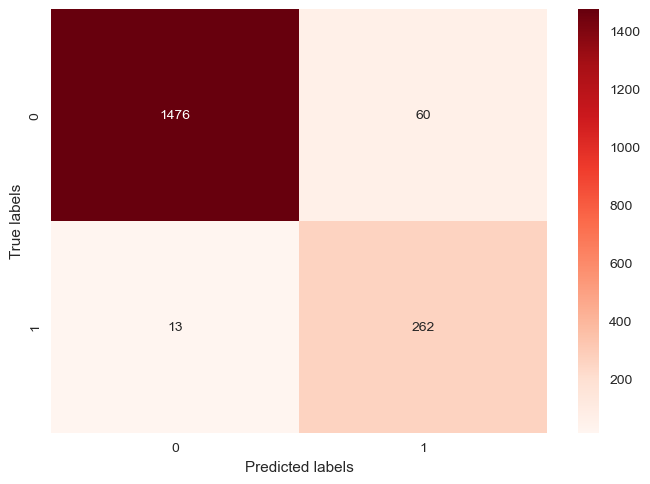

In [18]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [19]:
f1_score(y_test, y_pred)

0.8777219430485762

In [20]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

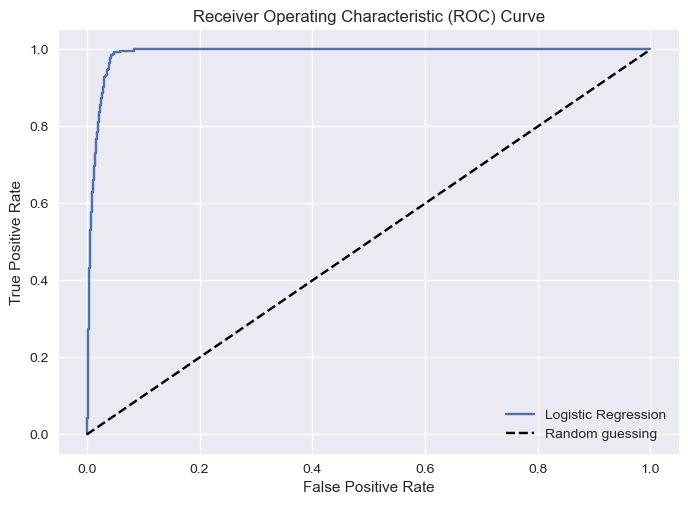

In [21]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [22]:
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [i for i in range(69,70)],
    'max_depth': [i for i in range(10,11)],
    'min_samples_split': [i for i in range(5,6)],
    'min_samples_leaf': [i for i in range(2,3)],
    'max_features': ['sqrt'],
    'class_weight': [{0: .26, 1: .73}]
}
rf = RandomForestClassifier(random_state= 42)

In [23]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.26, 1: 0.73}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 69}
Best score: 0.8640912579024966


In [24]:
auc2 = roc_auc_score(y_test, proba[:,1])
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9863257575757577
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1536
           1       0.81      0.91      0.86       275

    accuracy                           0.95      1811
   macro avg       0.90      0.94      0.92      1811
weighted avg       0.96      0.95      0.96      1811



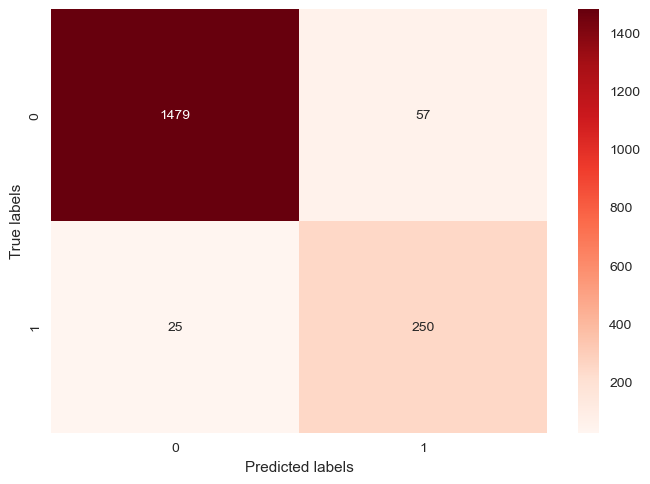

In [25]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [26]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

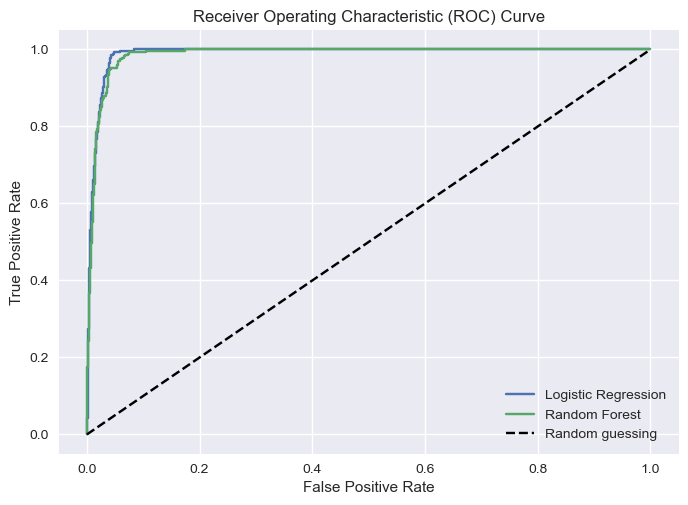

In [27]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [28]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [29]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.8847821989053525


In [30]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [31]:
auc3 = roc_auc_score(y_test, y_)
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9898958333333334
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1536
           1       0.87      0.88      0.87       275

    accuracy                           0.96      1811
   macro avg       0.92      0.93      0.93      1811
weighted avg       0.96      0.96      0.96      1811



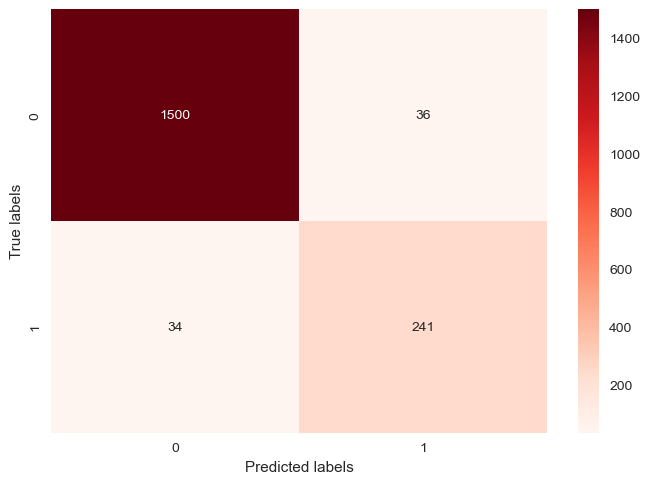

In [32]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [33]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

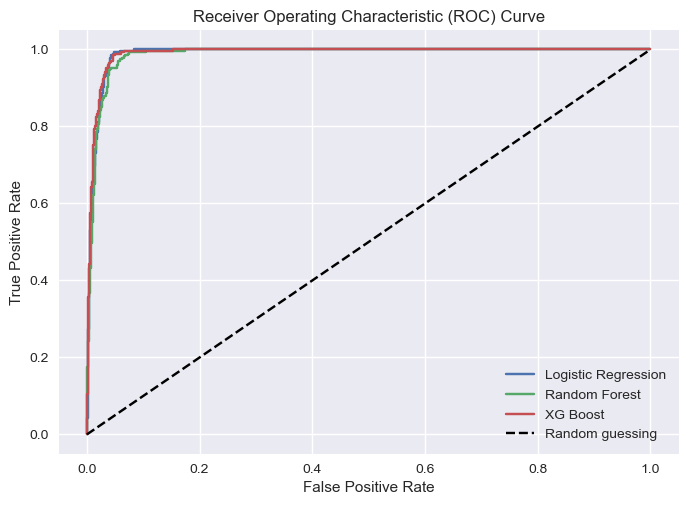

In [34]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [35]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [36]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [37]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
182/182 [==============================] - 0s 862us/step - loss: 0.3360 - precision: 0.3509 - recall: 0.1253 - val_loss: 0.1843 - val_precision: 0.8588 - val_recall: 0.7343
Epoch 2/50
182/182 [==============================] - 0s 572us/step - loss: 0.1215 - precision: 0.8347 - recall: 0.8369 - val_loss: 0.0923 - val_precision: 0.8769 - val_recall: 0.8261
Epoch 3/50
182/182 [==============================] - 0s 524us/step - loss: 0.0854 - precision: 0.8345 - recall: 0.9313 - val_loss: 0.0860 - val_precision: 0.8906 - val_recall: 0.8261
Epoch 4/50
182/182 [==============================] - 0s 495us/step - loss: 0.0794 - precision: 0.8415 - recall: 0.9447 - val_loss: 0.0810 - val_precision: 0.8861 - val_recall: 0.8647
Epoch 5/50
182/182 [==============================] - 0s 483us/step - loss: 0.0746 - precision: 0.8451 - recall: 0.9488 - val_loss: 0.0755 - val_precision: 0.8791 - val_recall: 0.9130
Epoch 6/50
182/182 [==============================] - 0s 489us/step - loss: 0.07

182/182 [==============================] - 0s 488us/step - loss: 0.0305 - precision: 0.9366 - recall: 0.9757 - val_loss: 0.1274 - val_precision: 0.9157 - val_recall: 0.7343
Epoch 46/50
182/182 [==============================] - 0s 468us/step - loss: 0.0318 - precision: 0.9301 - recall: 0.9690 - val_loss: 0.0896 - val_precision: 0.8916 - val_recall: 0.8744
Epoch 47/50
182/182 [==============================] - 0s 466us/step - loss: 0.0313 - precision: 0.9336 - recall: 0.9663 - val_loss: 0.0856 - val_precision: 0.8857 - val_recall: 0.8986
Epoch 48/50
182/182 [==============================] - 0s 459us/step - loss: 0.0294 - precision: 0.9355 - recall: 0.9771 - val_loss: 0.1145 - val_precision: 0.9218 - val_recall: 0.7971
Epoch 49/50
182/182 [==============================] - 0s 459us/step - loss: 0.0275 - precision: 0.9478 - recall: 0.9784 - val_loss: 0.1007 - val_precision: 0.9031 - val_recall: 0.8551
Epoch 50/50
182/182 [==============================] - 0s 461us/step - loss: 0.0282 - p

In [38]:
y_ = ann.predict(X_test)

57/57 [==============================] - 0s 258us/step


In [39]:
y_= y_.reshape(y_.shape[0],)

In [40]:
y_pred= np.array([round(i+.25) for i in y_])

In [41]:
auc4 = roc_auc_score(y_test, y_)
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9871117424242424
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1536
           1       0.87      0.96      0.91       275

    accuracy                           0.97      1811
   macro avg       0.93      0.97      0.95      1811
weighted avg       0.97      0.97      0.97      1811



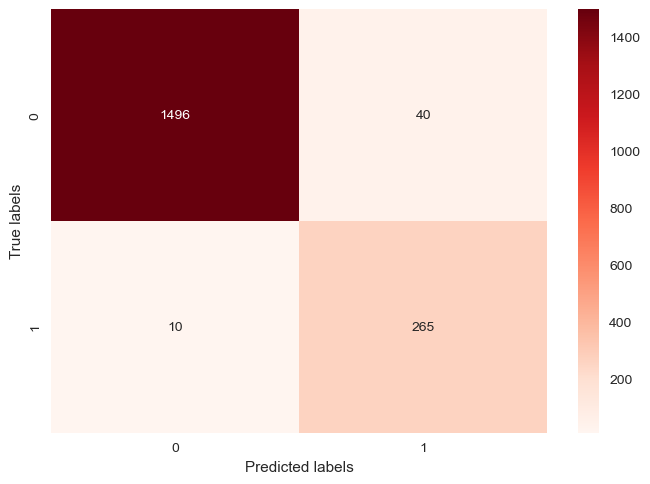

In [42]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [43]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

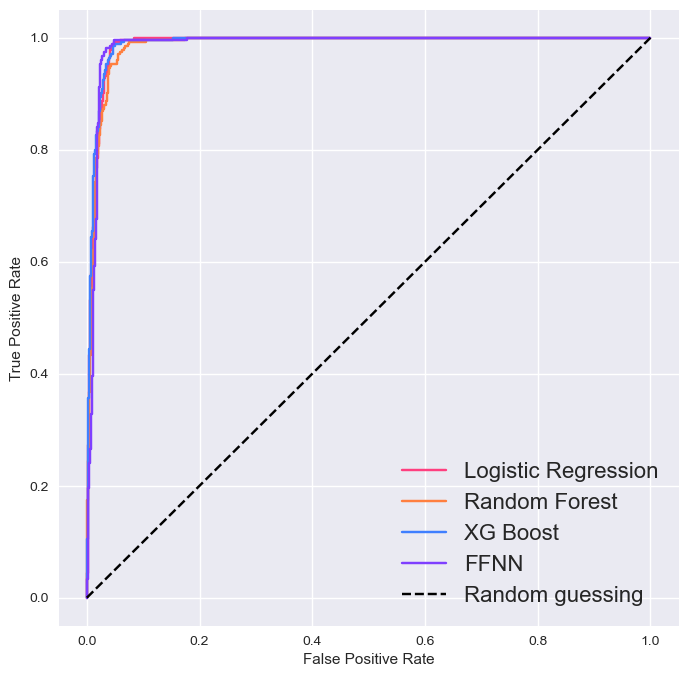

In [44]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff3f7f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f3f")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#3f7fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f3fff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_alg.png")
plt.show()

## Model Evaluations

In [45]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9597 & 0.9547 & 0.9613 & 0.9724 \\
   Recall & 0.9527 & 0.9091 & 0.8764 & 0.9636 \\
Precision & 0.8137 & 0.8143 & 0.8700 & 0.8689 \\
 F1-Score & 0.8777 & 0.8591 & 0.8732 & 0.9138 \\
      AUC & 0.9888 & 0.9863 & 0.9899 & 0.9871 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [46]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [47]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [48]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-2.3362558454790836, 5.183570493689523, 0.09969753661223985)

In [49]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [50]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.3239374517737391)

In [51]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-1.1334813207694574, 1.9373973469155021, -0.046267512343037484)

In [52]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [53]:
IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [54]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [55]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

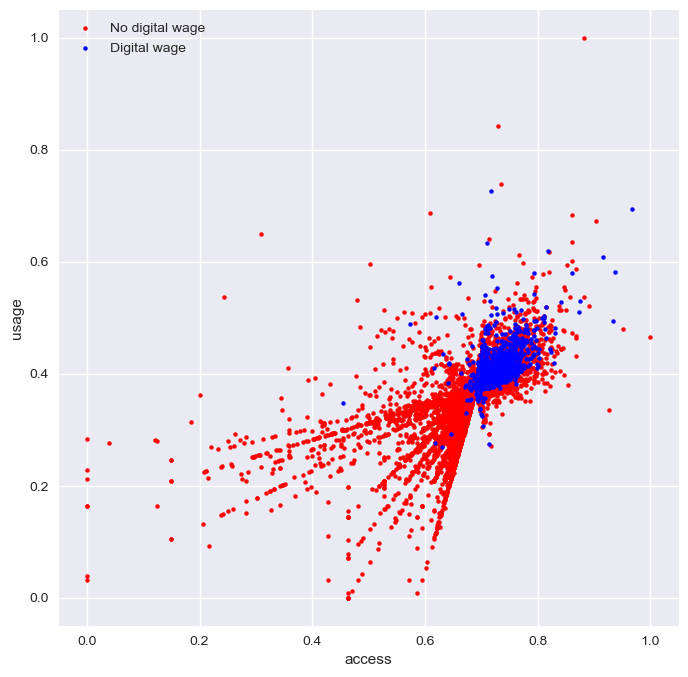

In [56]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.25,1.05])
#plt.ylim([-0.05,.75])
plt.savefig('../../images/find_alg')
plt.show()

In [57]:
IND_fin['access'].describe()

count    9053.000000
mean        0.676063
std         0.074236
min         0.000000
25%         0.657863
50%         0.678293
75%         0.713726
max         1.000000
Name: access, dtype: float64

In [58]:
IND_fin['usage'].describe()

count    9053.000000
mean        0.354040
std         0.065305
min         0.000000
25%         0.318504
50%         0.355148
75%         0.393611
max         1.000000
Name: usage, dtype: float64

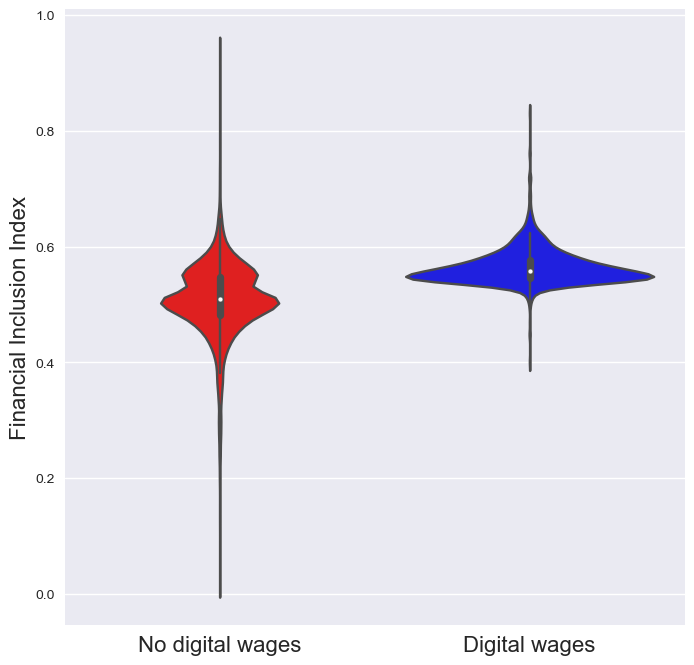

In [59]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)
plt.savefig('../../images/ind_alg')

# Show the plot
plt.show()

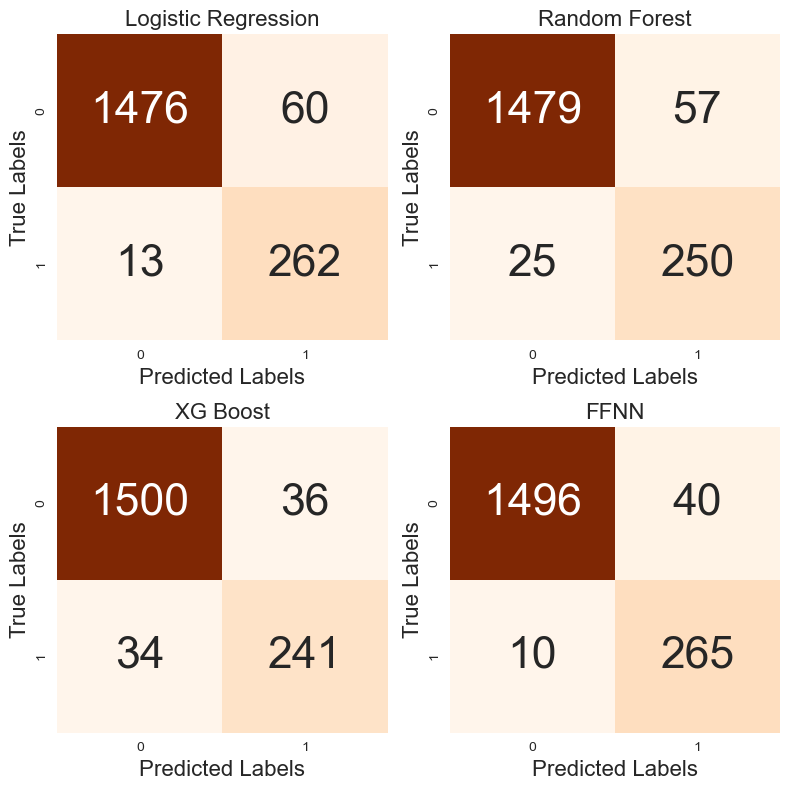

[CV] END ...............C=1, class_weight={0: 0.68, 1: 0.96}; total time=   0.0s
[CV] END class_weight={0: 0.26, 1: 0.73}, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=69; total time=   0.4s
[CV] END ...............C=1, class_weight={0: 0.68, 1: 0.96}; total time=   0.0s
[CV] END class_weight={0: 0.26, 1: 0.73}, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=69; total time=   0.5s
[CV] END ...............C=1, class_weight={0: 0.68, 1: 0.96}; total time=   0.0s
[CV] END class_weight={0: 0.26, 1: 0.73}, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=69; total time=   0.5s
[CV] END ...............C=1, class_weight={0: 0.68, 1: 0.96}; total time=   0.0s
[CV] END class_weight={0: 0.26, 1: 0.73}, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=69; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_es

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="Oranges", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_mena.png')
# Display the plot
plt.show()

## Feature importance

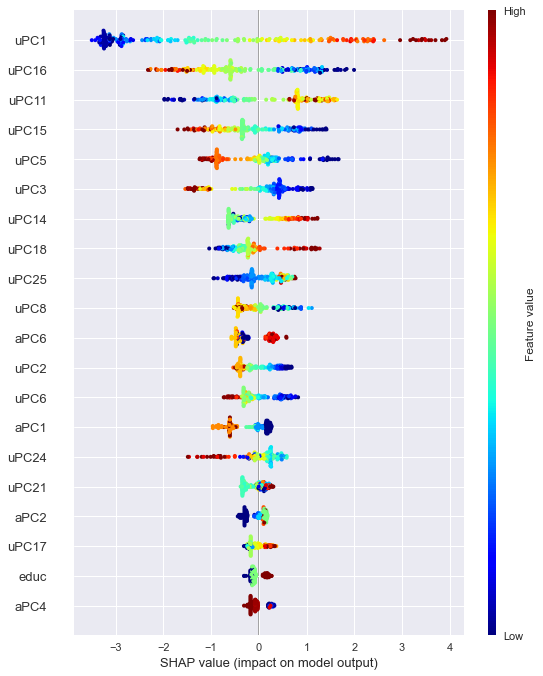

In [85]:
explainer = shap.TreeExplainer(best_xgb)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [62]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

In [73]:
a= a[['aPC6', 'aPC1', 'aPC2', 'aPC4']]
u= u[['uPC1', 'uPC16', 'uPC11', 'uPC15', 'uPC5', 'uPC3', 'uPC14', 'uPC18', 'uPC25', 'uPC8', 'uPC2', 
      'uPC6', 'uPC24', 'uPC21', 'uPC17']]

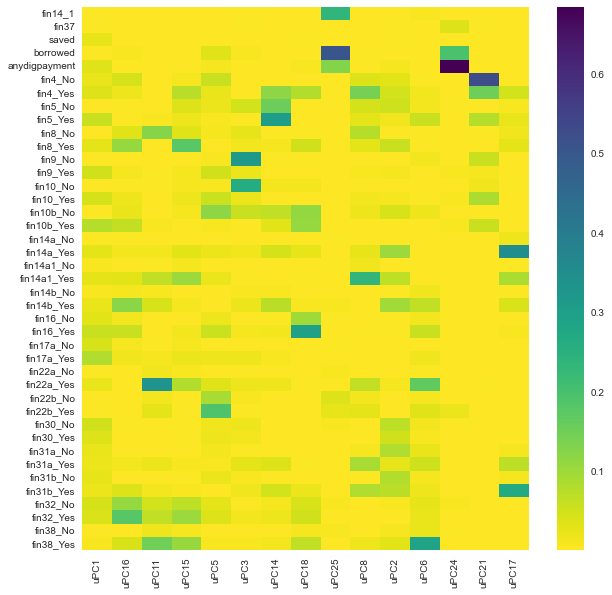

In [80]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_alg.png')
plt.show()

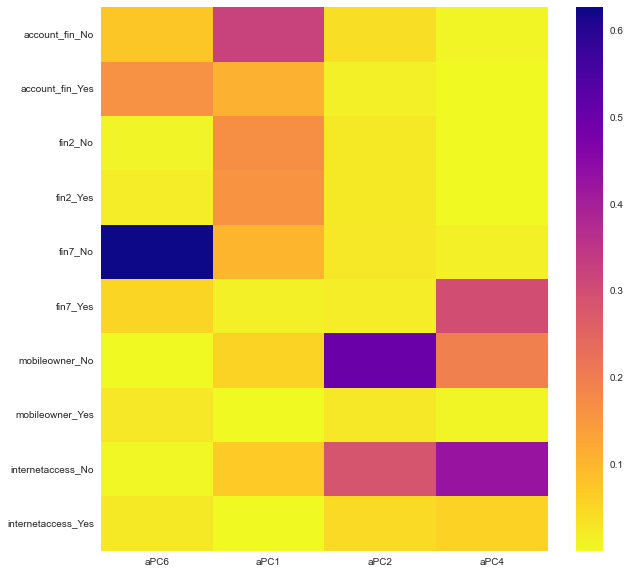

In [75]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_alg.png')
plt.show()

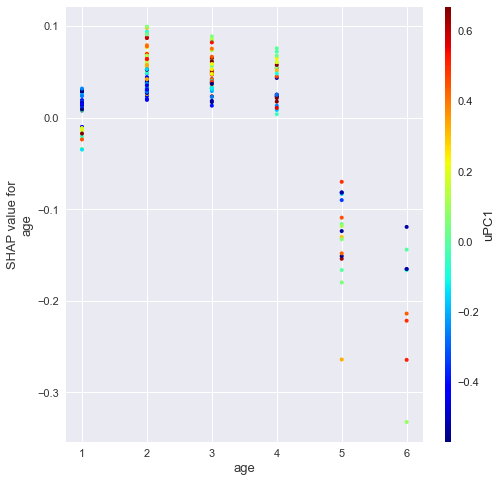

In [86]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

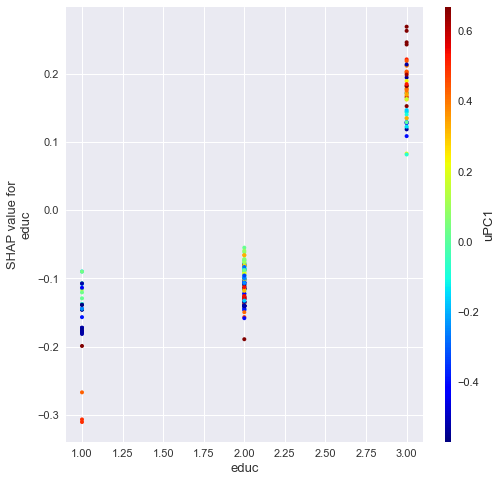

In [87]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

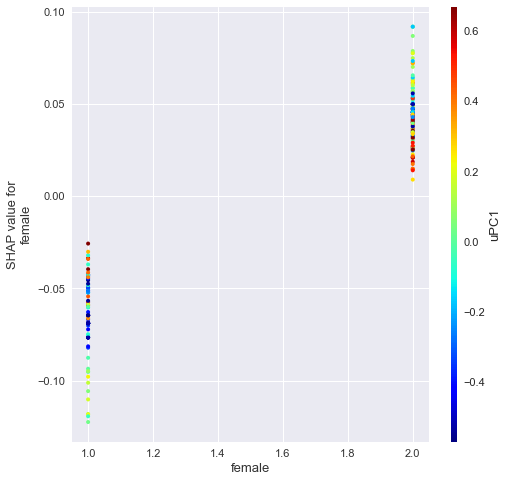

In [88]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

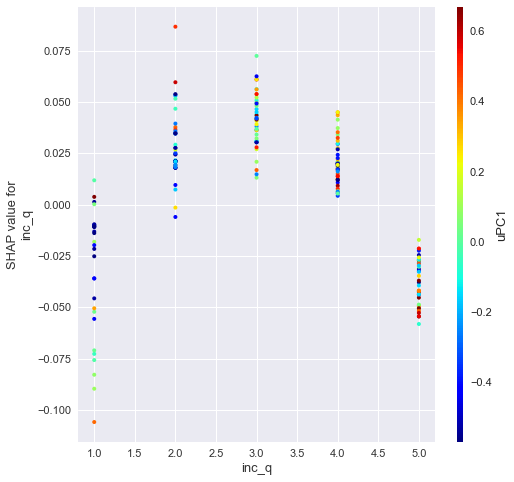

In [89]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

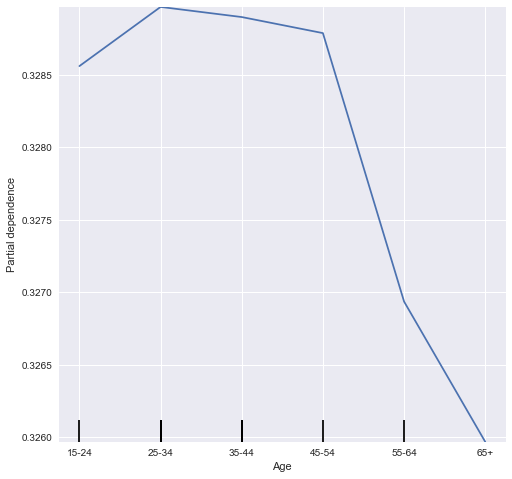

In [121]:
fig, ax= plt.subplots(figsize=(8,8))
p_age= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['age'], ax=ax)
new_labels = ['15-24', '25-34', '35-44', '45-54', '55-64', '65+']
x=[1,2,3,4,5,6]
plt.xticks(x, new_labels)
plt.xlabel('Age')
plt.savefig('../../images/pd_age_alg.png')
plt.show()

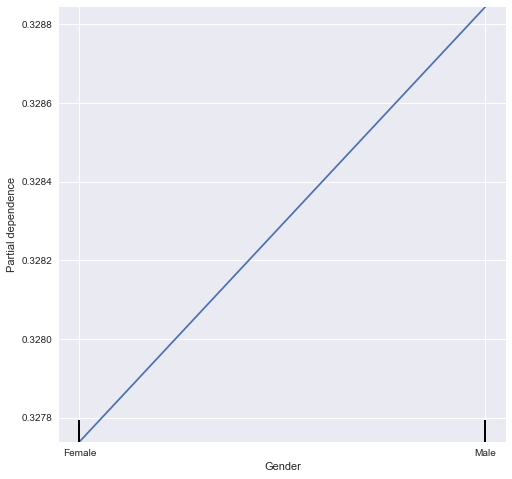

In [122]:
fig, ax= plt.subplots(figsize=(8,8))
p_female= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['female'], ax=ax)
new_labels = ['Female', 'Male']
x=[1,2]
plt.xticks(x, new_labels)
plt.xlabel('Gender')
plt.savefig('../../images/pd_gen_alg.png')
plt.show()

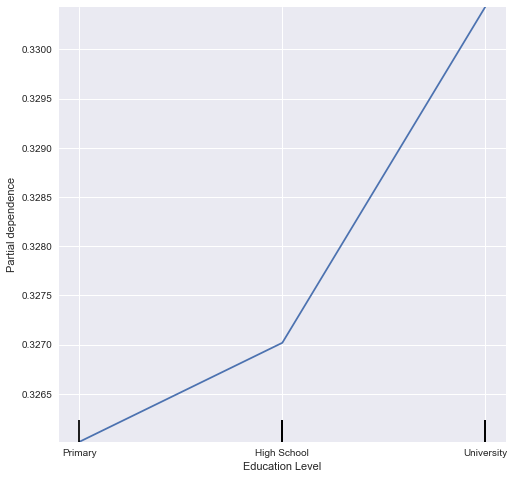

In [123]:
fig, ax= plt.subplots(figsize=(8,8))
p_educ= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['educ'], ax=ax)
new_labels = ['Primary', 'High School', 'University']
x=[1,2,3]
plt.xticks(x, new_labels)
plt.xlabel('Education Level')
plt.savefig('../../images/pd_educ_alg.png')
plt.show()

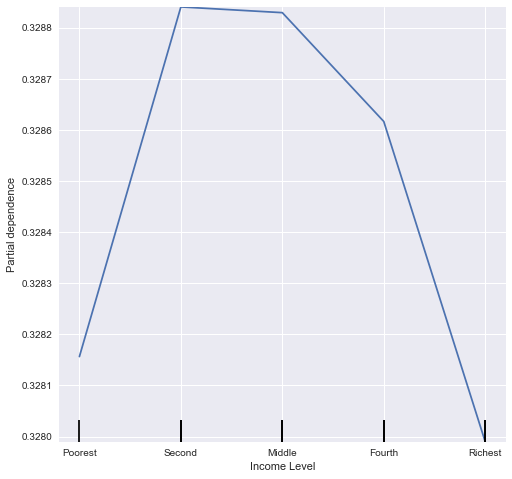

In [124]:
fig, ax= plt.subplots(figsize=(8,8))
p_inc= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['inc_q'], ax=ax)
new_labels = ['Poorest', 'Second', 'Middle', 'Fourth', 'Richest']
x=[1,2,3,4,5]
plt.xticks(x, new_labels)
plt.xlabel('Income Level')
plt.savefig('../../images/pd_inc_alg.png')
plt.show()